# Hidden Markov Model - Generalized Linear Model (HMM GLM) Tutorial Notebook #

This notebook will teach you how to use HMM-GLMs using StateSpaceDynamics.jl. HMM-GLMs are an extension of HMMs where the observation is dependent not only on the latent state, but also an input. These can be conceptualized as switching regression models, and are referred to as such throughout StateSpaceDynamics.jl

## 0: Environment Setup

In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

StateSpaceDynamics

## 1: Introduction to HMM-GLMs ##

For a detailed explanation of the core Hidden Markov Model (HMM) concepts, including the hidden state evolution and transition matrix, please refer to the notebook `hmm.ipynb`. The primary difference between a standard HMM and an HMM-GLM (Hidden Markov Model with Generalized Linear Model) lies in the emission model.

Emission Model in HMM-GLMs
In an HMM-GLM, instead of directly modeling the emissions (observations) as a simple distribution (e.g., Gaussian or categorical), the emissions follow a generalized linear model (GLM). This means the observed data $x_t$ is a linear function of some input features, with parameters dependent on the hidden state $z_t$. 

Specifically:
$x_t=g^{-1}(X_tβ_{z_t})+ϵ$

$X_t$: Input feature vector at time $t$.

$\beta_{z_t}$: Regression coefficients for the hidden state $z_t$.

$g^{-1}(\cdot)$: Link function appropriate for the distribution of $x_t$ (e.g., logistic for binary outcomes, identity for continuous).

$\epsilon$: Noise term, often assumed to follow a Gaussian distribution.

The HMM-GLM can be conceptualized as a switching regression model, where the coefficients of the regression change discretely over time.

### Example

In the following example we will demonstrate how to create, sample from, and fit a Switching Gaussian Regression model using StateSpaceDynamics.jl

In [2]:
# Common dimensions for both models
input_dim = 2
output_dim = 2

# Parameters for the first Gaussian regression model
β1 = [10.0 5.5; -7 3.2; -4.1 5.0] # Coefficients (3x2 matrix: 1 intercept + 2 features for 2 outputs)
Σ1 = [0.1 0.01; 0.01 0.2]  # Covariance matrix (2x2 matrix, since output_dim is 2)
include_intercept1 = true
λ1 = 0.01

# Instantiate the first Gaussian regression
regression1 = SSD.GaussianRegressionEmission(GaussianRegression(input_dim, output_dim, β1, Σ1, include_intercept1, λ1))


# Parameters for the first Gaussian regression model
β2 = [0.0 -5.0; -5.0 0.0; 4.0 -2.0]  # Coefficients (3x2 matrix: 1 intercept + 2 features for 2 outputs)
Σ2 = [0.01 0.01; 0.01 0.05]  # Covariance matrix (2x2 matrix, since output_dim is 2)
include_intercept2 = true
λ2 = 0.01

# Instantiate the second Gaussian regression
regression2 = SSD.GaussianRegressionEmission(GaussianRegression(input_dim, output_dim, β2, Σ2, include_intercept2, λ2))


# Initialize the Switching Gaussian Regression Model
model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=2)

# Assign the prebuild regression models to each state
model.B[1] = regression1
model.B[2] = regression2

# Assign the HMM parameters
model.πₖ = [0.5; 0.5]
model.A = [0.95 0.05; 0.1 0.9]


2×2 Matrix{Float64}:
 0.95  0.05
 0.1   0.9

## 2 Sampling from an HMM-GLM

Now that we have an HMM-GLM model, lets sample from it! Since this is a switching regression model, we need to generate some input data in order to sample the emission and hidden states.

In [3]:
Φ = rand(500,2)  # The random input data
n=500  # The number of samples we wish to generate

true_labels, data = SSD.sample(model, Φ, n=n)

([2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 2, 2, 2, 2, 2, 2, 2], [-1.049126678284319 -5.696847192532905; -1.7618311115411016 -5.479238411964919; … ; -2.8827790247970166 -5.571112631641582; -0.8918977336550936 -5.555432204598302])

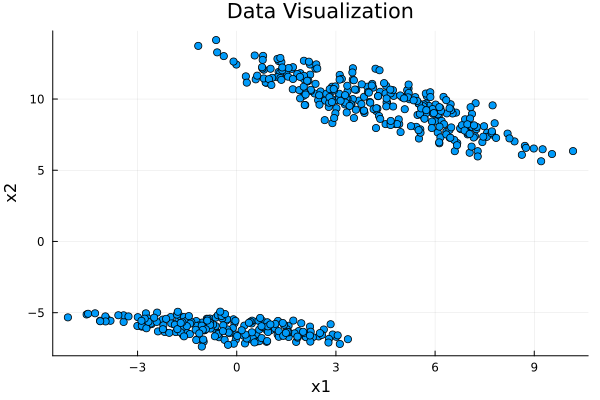

In [4]:
plot(data[1:end, 1], data[1:end, 2], seriestype=:scatter, label=false)
title!("Data Visualization")
xlabel!("x1")
ylabel!("x2")

## 3. Fitting an HMM-GLM

In [5]:
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=2, output_dim=2)
ll = SSD.fit!(test_model, Φ, data)

New Function in use...


Running EM algorithm...   2%|█                           |  ETA: 0:03:21

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:04


5-element Vector{Float64}:
   -Inf
 -1550.5888507204984
 -1404.9062236349127
 -1404.9062220505557
 -1404.90622194819

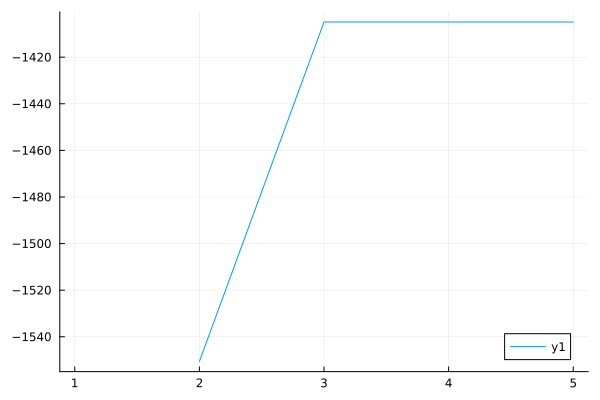

In [6]:
plot(ll)

In [11]:
println(model.B[1].β)
println(test_model.B[1].β)

[10.0 5.5; -7.0 3.2; -4.1 5.0]
[0.6468286746454586 0.5433476606906842; -0.0919661811270453 -0.01963018193278034; 0.026096394248398245 0.006796367472744109]
